In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import overpy not using, wasn't giving nds, which we need for ordering
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import xmltodict # using this instead of overpy to parse OSM data manually ourselves
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys
sys.path.append(f'/media/beans/ssd/bespoke')
sys.path.append(f'/home/beans/bespoke')

from map_utils import *

In [39]:
# We'll call this once in the beginning. Just keep loaded in memory. When venturing further out, 
# we'll need to refresh this every so often.
# total process of fetching 10 - 20 km radius in each direction will be a couple hundred milliseconds
# in production version, this will probably be running every minute or so. We have time to keep a healthy buffer

far_radius = 40_000 #10_000
lat, lon = 45.023867, -122.741862
bbox_angle = np.degrees(far_radius / EARTH_RADIUS)
bbox_angle

0.35961575090589876

In [40]:
bbox_str = f'{str(lat - bbox_angle)},{str(lon - bbox_angle)},{str(lat + bbox_angle)},{str(lon + bbox_angle)}'
bbox_str

'44.66425124909411,-123.1014777509059,45.3834827509059,-122.3822462490941'

In [41]:
silverton_area_bbox_str = f'{str(44.85017681566702)},{-122.83272781942897},{45.07848012852752},{-122.49831789424171}'
silverton_area_bbox_str

'44.85017681566702,-122.83272781942897,45.07848012852752,-122.49831789424171'

In [42]:
bbox_str = silverton_area_bbox_str

In [43]:
q = """
    way(""" + bbox_str + """)
      [highway]
      [highway!~"^(footway|path|corridor|bridleway|steps|cycleway|construction|bus_guideway|escape|service|track)$"];
    (._;>;);
    out;
    """
q

'\n    way(44.85017681566702,-122.83272781942897,45.07848012852752,-122.49831789424171)\n      [highway]\n      [highway!~"^(footway|path|corridor|bridleway|steps|cycleway|construction|bus_guideway|escape|service|track)$"];\n    (._;>;);\n    out;\n    '

In [44]:
%%time

# grabbing osm data from our local db. Could also grab this from online, if wanted eg big dump of certain area, could then
# store that offline and not need to deal w local db at all
completion = subprocess.run(["/home/beans/osm-3s_v0.7.56.9/bin/osm3s_query", "--db-dir=/media/beans/ssd/osm/db", f'--request={q}'], check=True, capture_output=True)

CPU times: user 4.74 ms, sys: 8.39 ms, total: 13.1 ms
Wall time: 232 ms


In [45]:
completion.stdout

b'<?xml version="1.0" encoding="UTF-8"?>\n<osm version="0.6" generator="Overpass API 0.7.56.9 76e5016d">\n<note>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</note>\n<meta osm_base=""/>\n\n  <node id="37015657" lat="45.1259460" lon="-122.5782600"/>\n  <node id="37241461" lat="45.0152310" lon="-122.5220540"/>\n  <node id="37241692" lat="45.0149350" lon="-122.5914160"/>\n  <node id="37245317" lat="45.0729166" lon="-122.6627376"/>\n  <node id="37245470" lat="45.0660490" lon="-122.6814940"/>\n  <node id="37246800" lat="45.0628768" lon="-122.5190105"/>\n  <node id="37248082" lat="44.9867943" lon="-122.5131866"/>\n  <node id="37250802" lat="45.0290321" lon="-122.5551122"/>\n  <node id="37258985" lat="44.9179058" lon="-122.4998361"/>\n  <node id="37258986" lat="44.9180058" lon="-122.4996949"/>\n  <node id="37258988" lat="44.9182500" lon="-122.4993800"/>\n  <node id="37258992" lat="44.9184930" lon="-122.4991270"/>\n  <node id="37258995

In [46]:
%%time

# Manual parsing of osm data, which is just xml after all

rr = xmltodict.parse(completion.stdout)
rr

CPU times: user 360 ms, sys: 11.3 ms, total: 371 ms
Wall time: 371 ms


{'osm': {'@version': '0.6',
  '@generator': 'Overpass API 0.7.56.9 76e5016d',
  'note': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.',
  'meta': {'@osm_base': ''},
  'node': [{'@id': '37015657', '@lat': '45.1259460', '@lon': '-122.5782600'},
   {'@id': '37241461', '@lat': '45.0152310', '@lon': '-122.5220540'},
   {'@id': '37241692', '@lat': '45.0149350', '@lon': '-122.5914160'},
   {'@id': '37245317', '@lat': '45.0729166', '@lon': '-122.6627376'},
   {'@id': '37245470', '@lat': '45.0660490', '@lon': '-122.6814940'},
   {'@id': '37246800', '@lat': '45.0628768', '@lon': '-122.5190105'},
   {'@id': '37248082', '@lat': '44.9867943', '@lon': '-122.5131866'},
   {'@id': '37250802', '@lat': '45.0290321', '@lon': '-122.5551122'},
   {'@id': '37258985', '@lat': '44.9179058', '@lon': '-122.4998361'},
   {'@id': '37258986', '@lat': '44.9180058', '@lon': '-122.4996949'},
   {'@id': '37258988', '@lat': '44.9182500', '@lon': '-122.4993800'

In [47]:
%%time

# Rearranging our data in a flat way so we can filter quickly based on node distance from ego, THEN group by way
# this cell and the next outputs flat tabular style data w three properties: way_id, lat, lon

ways = rr['osm']['way']
nodes = rr['osm']['node']
nodes_dict = {}
for n in nodes:
    nodes_dict[n['@id']] = (float(n["@lat"]), float(n["@lon"]))
nodes_dict

CPU times: user 22.6 ms, sys: 0 ns, total: 22.6 ms
Wall time: 22.4 ms


{'37015657': (45.125946, -122.57826),
 '37241461': (45.015231, -122.522054),
 '37241692': (45.014935, -122.591416),
 '37245317': (45.0729166, -122.6627376),
 '37245470': (45.066049, -122.681494),
 '37246800': (45.0628768, -122.5190105),
 '37248082': (44.9867943, -122.5131866),
 '37250802': (45.0290321, -122.5551122),
 '37258985': (44.9179058, -122.4998361),
 '37258986': (44.9180058, -122.4996949),
 '37258988': (44.91825, -122.49938),
 '37258992': (44.918493, -122.499127),
 '37258995': (44.918738, -122.498855),
 '37258999': (44.918931, -122.498587),
 '37259000': (44.919136, -122.498287),
 '37259002': (44.919361, -122.497998),
 '37259005': (44.91958, -122.497707),
 '37259008': (44.919795, -122.49741),
 '37259011': (44.920017, -122.49712),
 '37259016': (44.92022, -122.496816),
 '37259018': (44.920466, -122.496553),
 '37259019': (44.92077, -122.496357),
 '37259022': (44.921058, -122.496121),
 '37259025': (44.921285, -122.495885),
 '37259028': (44.921415, -122.495821),
 '37259031': (44.9215

In [48]:
%%time
way_ids, lats, lons = [], [], []
for way in (ways if type(ways)==list else [ways]):
    way_id = int(way["@id"])
    for nd in way['nd']:
        nd_id = nd['@ref']
        node = nodes_dict[nd_id]
        way_ids.append(way_id)
        lats.append(node[0])
        lons.append(node[1])
lats, lons, way_ids = np.array(lats), np.array(lons), np.array(way_ids)
lats.shape, lons.shape #TODO stack these three arrays together for better perf later, slight

CPU times: user 30.7 ms, sys: 0 ns, total: 30.7 ms
Wall time: 30.3 ms


((24204,), (24204,))

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 15 ms


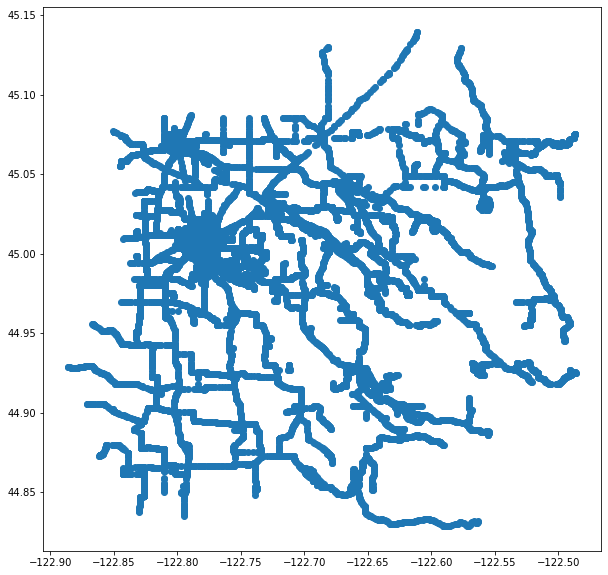

In [49]:
%%time
plt.figure(figsize=(10,10))
plt.scatter(lons, lats)

In [50]:
lats.dtype

dtype('float64')

In [51]:
# Narrowing down to window around vehicle. 
# Everything below will be called every frame, so it should take only a few ms as to not impede on our 50ms modeld loop

#current_lat, current_lon = 44.973490, -122.645679 #nabq curves
current_lat, current_lon = 45.023867, -122.741862 # start sabq
vehicle_heading = .7 + np.pi/2 # need this hardcoded rotater

In [52]:
lats, lons, way_ids = prepare_small_map_nodes(lats, lons, way_ids, current_lat, current_lon, vehicle_heading, CLOSE_BUFFER)
lats.shape, lons.shape, way_ids.shape

((17,), (17,), (17,))

In [53]:
small_map = draw_small_map(lats, lons, way_ids)
small_map.shape

(100, 80, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


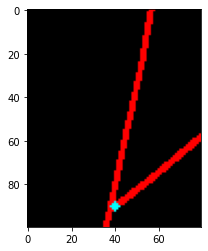

In [54]:
plt.imshow(small_map)